In [ ]:
pip install python-sat #Cài đặt thư viện python-sat

In [ ]:
from pysat.solvers import Glucose3
from pysat.formula import CNF
from itertools import combinations
import time
import tracemalloc

# Tạo lớp biến hỗ trợ tương tự như VariableFactory(ex)
class VariableFactory:
    def __init__(self):
        # Khởi tạo đếm số lượng biến (bắt đầu từ 1)
        self.var_count = 1

        # Lưu trữ các biến theo tên (tên -> id biến)
        self.vars = {}

        # Lưu trữ các biến theo id (id -> tên biến)
        self.reverse_vars = {}

    # Hàm lấy id của một biến từ tên, nếu chưa có biến đó thì tạo mới
    def get_var(self, name):
        # Nếu tên biến chưa tồn tại trong self.vars, ta tạo mới id cho biến đó
        if name not in self.vars:
            # Gán id mới cho biến
            self.vars[name] = self.var_count
            # Lưu tên của biến theo id mới
            self.reverse_vars[self.var_count] = name
            # Tăng số lượng biến
            self.var_count += 1
        # Trả về id của biến đã được tạo ra (hoặc đã tồn tại)
        return self.vars[name]

    # Hàm tạo biến bắt đầu của hoạt động tại một thời điểm
    def start(self, activity_id, time):
        # Tạo tên biến theo cú pháp 'start_{activity_id}_{time}'
        return self.get_var(f'start_{activity_id}_{time}')

    # Hàm tạo biến chạy của hoạt động tại một thời điểm
    def run(self, activity_id, time):
        # Tạo tên biến theo cú pháp 'run_{activity_id}_{time}'
        return self.get_var(f'run_{activity_id}_{time}')

    # Hàm tạo biến tiêu thụ tài nguyên của hoạt động tại một thời điểm
    def consume(self, activity_id, resource_id, time, index):
        # Tạo tên biến theo cú pháp 'consume_{activity_id}_{resource_id}_{time}_{index}'
        return self.get_var(f'consume_{activity_id}_{resource_id}_{time}_{index}')

    # Hàm tạo biến phụ trợ (auxiliary variable) tại một thời điểm
    def aux(self, time):
        # Tạo tên biến theo cú pháp 'aux_{time}'
        return self.get_var(f'aux_{time}')

    # Hàm lấy tên của một biến từ id của nó
    def get_var_name(self, var_id):
        # Trả về tên của biến từ id, nếu không tìm thấy trả về None
        return self.reverse_vars.get(var_id, None)

# Tiện ích thêm mệnh đề vào solver
def add_clause(solver, clause):
    solver.add_clause(clause)

# Phép toán (1) đến (4): Quan hệ thứ tự giữa các hoạt động
# encode_relation_fs: Quan hệ "Finish-to-Start" (FS)
def encode_relation_fs(solver, vf, max_time, activity1_id, activity2_id, duration1):
    for t in range(max_time):
        start1 = vf.start(activity1_id, t) # Tạo biến bắt đầu của activity1 tại thời điểm t
        for k in range(t + duration1):     # Kiểm tra tất cả thời điểm k từ t đến (t + duration1)
            add_clause(solver, [-start1, -vf.start(activity2_id, k)]) # Không thể bắt đầu activity2 tại thời điểm k

# encode_relation_ss: Quan hệ "Start-to-Start" (SS)
def encode_relation_ss(solver, vf, max_time, activity1_id, activity2_id):
    for t in range(max_time):
        start1 = vf.start(activity1_id, t) # Tạo biến bắt đầu của activity1 tại thời điểm t
        for k in range(t):                 # Kiểm tra các thời điểm trước thời điểm t
            add_clause(solver, [-start1, -vf.start(activity2_id, k)]) # Không thể bắt đầu activity2 tại thời điểm k

# encode_relation_ff: Quan hệ "Finish-to-Finish" (FF)
def encode_relation_ff(solver, vf, max_time, activity1_id, activity2_id, duration1, duration2):
    for t in range(max_time - duration2):
        start1 = vf.start(activity1_id, t)         # Tạo biến bắt đầu của activity1 tại thời điểm t
        for k in range(t + duration1 - duration2): # Kiểm tra thời điểm k sau khi (t + duration1 - duration2)
            add_clause(solver, [-start1, -vf.start(activity2_id, k)]) # Không thể bắt đầu activity2 tại thời điểm k

# encode_relation_sf: Quan hệ "Start-to-Finish" (SF)
def encode_relation_sf(solver, vf, max_time, activity1_id, activity2_id, duration2):
    for t in range(max_time):
        start1 = vf.start(activity1_id, t)         # Tạo biến bắt đầu của activity1 tại thời điểm t
        for k in range(max(0, t - duration2 + 1)): # Kiểm tra các thời điểm trước thời điểm t + duration2
            add_clause(solver, [-start1, -vf.start(activity2_id, k)]) # Không thể bắt đầu activity2 tại thời điểm k

# Phép toán (6) - ALK: Hoạt động bắt đầu muộn nhất có thể
def encode_unique_start_instant_alk(solver, vf, max_time, activity_id, duration):
    clause = [vf.start(activity_id, t) for t in range(max_time - duration + 1)]
    add_clause(solver, clause)
    for t1 in range(max_time - duration + 1):
        for t2 in range(t1 + 1, max_time - duration + 1):
            add_clause(solver, [-vf.start(activity_id, t1), -vf.start(activity_id, t2)])

# Phép toán (7): Giới hạn thời gian bắt đầu
def encode_start_in_time(solver, vf, max_time, activity_id, duration):
    for t in range(max_time - duration + 1, max_time):
        add_clause(solver, [-vf.start(activity_id, t)])

# Phép toán (8) và (9): Đảm bảo hoạt động chạy liên tục
def encode_runtime(solver, vf, max_time, activity_id, duration):
    for t in range(max_time):
        start_literal = vf.start(activity_id, t)
        for j in range(max_time):
            run_literal = vf.run(activity_id, j)
            if j < t:
                add_clause(solver, [-start_literal, -run_literal])
            elif t <= j < t + duration:
                add_clause(solver, [-start_literal, run_literal])
            else:
                add_clause(solver, [-start_literal, -run_literal])

# Phép toán (10): Quan hệ "finish-to-start"
def encode_relation_fs(solver, vf, max_time, activity1_id, activity2_id, duration1):
    for t in range(max_time):
        start1 = vf.start(activity1_id, t)
        for k in range(t + duration1):
            add_clause(solver, [-start1, -vf.start(activity2_id, k)])

# Phép toán (11): Quan hệ bắt đầu-bắt đầu (Start-to-Start, SS)
def encode_relation_ss(solver, vf, max_time, activity1_id, activity2_id):
    for t in range(max_time):
        start1 = vf.start(activity1_id, t)
        for k in range(t):
            add_clause(solver, [-start1, -vf.start(activity2_id, k)])

# Phép toán (12): Quan hệ kết thúc-kết thúc (Finish-to-Finish, FF)
def encode_relation_ff(solver, vf, max_time, activity1_id, activity2_id, duration1, duration2):
    for t in range(max_time - duration1 + 1):
        finish1 = vf.start(activity1_id, t)  # end of activity1
        for k in range(max_time - duration2 + 1):
            if k < t + duration1 - duration2:
                add_clause(solver, [-finish1, -vf.start(activity2_id, k)])

# Phép toán (13): Quan hệ bắt đầu-kết thúc (Start-to-Finish, SF)
def encode_relation_sf(solver, vf, max_time, activity1_id, activity2_id, duration2):
    for t in range(max_time):
        start1 = vf.start(activity1_id, t)
        for k in range(t + duration2, max_time):
            add_clause(solver, [-start1, -vf.start(activity2_id, k)])

# Phép toán (16): Mã hóa atoms tiêu thụ tài nguyên
def encode_consumption_atoms(solver, vf, max_time, activities, resources):
    for t in range(max_time):
        for activity in activities:
            for resource in resources:
                consumption = activity['consumption'].get(resource['id'], 0)
                for i in range(consumption):
                    consumption_var = vf.consume(activity["id"], resource["id"], t, i)
                    add_clause(solver, [-vf.run(activity["id"], t), consumption_var])

# Hàm giới hạn số lượng
def gen_cardinality_constraint(solver, variables, bound):
  # Nếu số lượng biến trong list nhỏ hơn hoặc bằng giới hạn, không cần phải thêm bất kỳ ràng buộc nào
    if len(variables) <= bound:
        return
    for i in range(len(variables) - bound): # Lặp qua danh sách các biến
        add_clause(solver, [-var for var in variables[i:i + bound + 1]])  # Thêm ràng buộc vào solver

Mục đích: Hàm encode_resource_constraint_cardinality mã hóa ràng buộc tài nguyên cho từng thời điểm t, đảm bảo tổng tài nguyên tiêu thụ không vượt quá dung lượng (capacity) của từng tài nguyên.

Tham số:
- solver: Bộ giải SAT (Glucose3), nơi các mệnh đề được thêm vào để giải bài toán.
- vf: Đối tượng của lớp VariableFactory, dùng để tạo và quản lý các biến SAT.
- max_time: Thời gian tối đa cho lịch trình.
- activities: Danh sách các hoạt động. Mỗi hoạt động có thông tin tiêu thụ tài nguyên trong activity["consumption"].
- resources: Danh sách tài nguyên. Mỗi tài nguyên có dung lượng (capacity).

In [ ]:
def encode_resource_constraint_cardinality(solver, vf, max_time, activities, resources):
    # Mã hóa các biến đại diện cho việc tiêu thụ tài nguyên
    encode_consumption_atoms(solver, vf, max_time, activities, resources)
    for t in range(max_time): # Lặp qua từng thời điểm t từ 0 đến max_time - 1
        for resource in resources: # Lặp qua từng tài nguyên trong danh sách resources.
            consumption_vars = [] # Tạo danh sách consumption_vars chứa các biến tiêu thụ tài nguyên tại thời điểm t
            for activity in activities:
                if activity["consumption"].get(resource["id"], 0) > 0:
                    for i in range(activity["consumption"][resource["id"]]):
                        consumption_vars.append(vf.consume(activity["id"], resource["id"], t, i))
            if consumption_vars:
                # Đảm bảo tổng số biến trong consumption_vars không vượt quá dung lượng (capacity) của tài nguyên.
                gen_cardinality_constraint(solver, consumption_vars, resource["capacity"])

Hàm encode_resource_constraint_powerset mã hóa ràng buộc tài nguyên bằng cách xét tất cả các tập con của hoạt động có thể xảy ra tại mỗi thời điểm t. Nếu tổng tài nguyên tiêu thụ của một tập con vượt quá dung lượng (capacity), thì tập con này được mã hóa để không xảy ra.

Tham số:
- solver: Bộ giải SAT (Glucose3), nơi các mệnh đề được thêm vào để giải bài toán.
- vf: Đối tượng của lớp VariableFactory, dùng để tạo và quản lý các biến SAT.
- max_time: Thời gian tối đa cho lịch trình.
- activities: Danh sách các hoạt động. Mỗi hoạt động có thông tin tiêu thụ tài nguyên trong activity["consumption"].
- resources: Danh sách tài nguyên. Mỗi tài nguyên có dung lượng (capacity).

In [ ]:
def encode_resource_constraint_powerset(solver, vf, max_time, activities, resources):
    for t in range(max_time):      # Lặp qua từng thời điểm t từ 0 đến max_time - 1
        for resource in resources: # Lặp qua từng tài nguyên trong danh sách resources.
            # Xét tất cả các tập con của danh sách activities có kích thước từ 1 đến len(activities)
            for subset_size in range(1, len(activities) + 1):
                for subset in combinations(activities, subset_size):
                    consumption_vars = []
                    total_consumption = 0
                    for activity in subset:
                        consumption = activity["consumption"].get(resource["id"], 0)
                        total_consumption += consumption
                        for i in range(consumption):
                            consumption_vars.append(vf.consume(activity["id"], resource["id"], t, i))
                    if total_consumption > resource["capacity"]:
                        add_clause(solver, [-var for var in consumption_vars])

In [ ]:
# Giải mã lời giải thành thông tin dễ hiểu
def decode_solution(model, vf):
    decoded_solution = {
        "activities_start_times": {},
        "activities_runtime": [],
        "resources_usage": []
    }

    for var in model:
        if var > 0:
            var_name = vf.get_var_name(abs(var))
            if "start" in var_name:
                parts = var_name.split('_')
                activity_id = int(parts[1])
                time = int(parts[2])
                decoded_solution["activities_start_times"][activity_id] = time
            elif "run" in var_name:
                parts = var_name.split('_')
                activity_id = int(parts[1])
                time = int(parts[2])
                decoded_solution["activities_runtime"].append((activity_id, time))
            elif "consume" in var_name:
                parts = var_name.split('_')
                activity_id = int(parts[1])
                resource_id = int(parts[2])
                time = int(parts[3])
                decoded_solution["resources_usage"].append((activity_id, resource_id, time))

    return decoded_solution

In [ ]:
# Advanced output
def print_solution(solution):
    print("Thời gian bắt đầu của mỗi hoạt động:")
    for activity, start_time in solution['activities_start_times'].items():
        print(f"  - Hoạt động {activity} bắt đầu tại thời điểm {start_time}")

    print("\nThời gian chạy của mỗi hoạt động:")
    for activity, time in solution['activities_runtime']:
        print(f"  - Hoạt động {activity} đang chạy tại thời điểm {time}")

    print("\nTiêu thụ tài nguyên theo thời gian:")
    resource_usage = {}
    for activity, resource, time in solution['resources_usage']:
        if time not in resource_usage:
            resource_usage[time] = []
        resource_usage[time].append((activity, resource))

    for time, usages in resource_usage.items():
        print(f"  - Tại thời điểm {time}:")
        for activity, resource in usages:
            print(f"    + Hoạt động {activity} tiêu thụ Tài nguyên {resource}")

In [ ]:
def validate(solution, activities, relations, resources, max_time):
    # Kiểm tra thời gian bắt đầu duy nhất cho mỗi hoạt động
    start_times = solution["activities_start_times"]
    for activity in activities:
        if activity["id"] not in start_times:
            return False, f"Hoạt động {activity['id']} không có thời gian bắt đầu."

    # Kiểm tra thời gian chạy liên tục
    runtime = solution["activities_runtime"]
    for activity in activities:
        duration = activity["duration"]
        start_time = start_times[activity["id"]]
        expected_runtime = set(range(start_time, start_time + duration))
        actual_runtime = {time for act, time in runtime if act == activity["id"]}
        if expected_runtime != actual_runtime:
            return False, f"Hoạt động {activity['id']} không chạy liên tục hoặc chạy sai thời gian."

    # Kiểm tra ràng buộc tiêu thụ tài nguyên
    resource_usage = solution["resources_usage"]
    for t in range(max_time):
        for resource in resources:
            total_consumption = sum(
                activity["consumption"].get(resource["id"], 0)
                for activity in activities
                if (activity["id"], resource["id"], t) in [
                    (act, res, time) for act, res, time in resource_usage
                ]
            )
            if total_consumption > resource["capacity"]:
                return False, f"Tài nguyên {resource['id']} vượt quá dung lượng tại thời điểm {t}."

    # Kiểm tra ràng buộc "finish-to-start"
    for relation in relations:
        task_1 = relation["task_id_1"]
        task_2 = relation["task_id_2"]
        start_1 = start_times[task_1]
        start_2 = start_times[task_2]
        duration_1 = next(a["duration"] for a in activities if a["id"] == task_1)
        if start_1 + duration_1 > start_2:
            return False, f"Quan hệ finish-to-start giữa {task_1} và {task_2} bị vi phạm."

    return True, "Lời giải hợp lệ."

In [ ]:
# Hàm giải RCPSP với output chi tiết
def solve_rcpsp(max_time, activities, relations, resources, consumptions, encoding_type):
    solver = Glucose3()
    vf = VariableFactory()

    # Mã hóa các hoạt động
    for activity in activities:
        encode_unique_start_instant_alk(solver, vf, max_time, activity["id"], activity["duration"])
        encode_start_in_time(solver, vf, max_time, activity["id"], activity["duration"])
        encode_runtime(solver, vf, max_time, activity["id"], activity["duration"])

    # Mã hóa quan hệ giữa các hoạt động
    for relation in relations:
        encode_relation_fs(solver, vf, max_time, relation["task_id_1"], relation["task_id_2"],
                           next(a["duration"] for a in activities if a["id"] == relation["task_id_1"]))

    # Mã hóa tiêu thụ tài nguyên
    for activity in activities:
        if "consumption" not in activity:
            activity["consumption"] = {}

    for consumption in consumptions:
        task_id = consumption["task_id"]
        resource_id = consumption["resource_id"]
        amount = -consumption["amount"]
        for activity in activities:
            if activity["id"] == task_id:
                activity["consumption"][resource_id] = amount

    # Mã hóa tài nguyên theo loại mã hóa
    if encoding_type == "BCC":
        encode_resource_constraint_cardinality(solver, vf, max_time, activities, resources)
    elif encoding_type == "Powerset":
        encode_resource_constraint_powerset(solver, vf, max_time, activities, resources)

    # Giải bài toán
    solution_found = solver.solve()

    # Hiển thị kết quả
    if solution_found:
        model = solver.get_model()
        solution = decode_solution(model, vf)  # Giải mã lời giải
        print_solution(solution)  # Hiển thị lời giải chi tiết

        # Kiểm tra tính hợp lệ của lời giải
        valid, message = validate(solution, activities, relations, resources, max_time)
        if valid:
            print("Lời giải hợp lệ.")
        else:
            print(f"Lời giải không hợp lệ: {message}")
    else:
        print("Không có lời giải thỏa mãn.")

    solver.delete()


In [ ]:
# Input
# Danh sách các hoạt động (task)
activities = [
    {"id": 0, "duration": 308, "name": "Task 0"},
    {"id": 1, "duration": 10, "name": "Task 1"},
    {"id": 2, "duration": 1, "name": "Task 2"},
    {"id": 3, "duration": 20, "name": "Task 3"},
    {"id": 4, "duration": 2, "name": "Task 4"},
    {"id": 5, "duration": 5, "name": "Task 5"},
    {"id": 6, "duration": 1, "name": "Task 6"}
]

# Danh sách các quan hệ giữa các hoạt động (aob - Activity on B Node), sử dụng mã hóa "finish-to-start" (FS)
relations = [
    {"task_id_1": 1, "task_id_2": 2, "relation_type": "ea"},  # Task 1 phải hoàn thành trước khi Task 2 bắt đầu
    {"task_id_1": 2, "task_id_2": 3, "relation_type": "ea"},
    {"task_id_1": 3, "task_id_2": 4, "relation_type": "ea"},
    {"task_id_1": 4, "task_id_2": 5, "relation_type": "ea"},
    {"task_id_1": 5, "task_id_2": 6, "relation_type": "ea"}
]

# Danh sách tiêu thụ tài nguyên (consumption) cho từng hoạt động và tài nguyên
consumptions = [
    {"task_id": 1, "resource_id": 0, "amount": -3},
    {"task_id": 3, "resource_id": 0, "amount": -3},
    {"task_id": 3, "resource_id": 1, "amount": -3},
    {"task_id": 3, "resource_id": 2, "amount": -3},
    {"task_id": 4, "resource_id": 0, "amount": -3},
    {"task_id": 4, "resource_id": 3, "amount": -3},
    {"task_id": 4, "resource_id": 4, "amount": -3},
    {"task_id": 5, "resource_id": 0, "amount": -3},
    {"task_id": 5, "resource_id": 3, "amount": -3},
    {"task_id": 5, "resource_id": 4, "amount": -3}
]

# Danh sách tài nguyên với dung lượng cho từng tài nguyên (resource)
resources = [
    {"id": 0, "capacity": 8, "name": "Resource 0"},
    {"id": 1, "capacity": 8, "name": "Resource 1"},
    {"id": 2, "capacity": 8, "name": "Resource 2"},
    {"id": 3, "capacity": 8, "name": "Resource 3"},
    {"id": 4, "capacity": 8, "name": "Resource 4"},
    {"id": 5, "capacity": 8, "name": "Resource 5"},
    {"id": 6, "capacity": 8, "name": "Resource 6"},
    {"id": 7, "capacity": 8, "name": "Resource 7"},
    {"id": 8, "capacity": 8, "name": "Resource 8"},
    {"id": 9, "capacity": 8, "name": "Resource 9"},
    {"id": 10, "capacity": 8, "name": "Resource 10"}
]

# Các tham số cấu hình cho giải bài toán
max_time = 350  # Thời gian tối đa dự kiến cho lịch trình (lớn hơn hoặc bằng tổng thời gian tất cả các task)

In [ ]:
def validate_input(max_time, activities, relations, resources, consumptions):
    # Kiểm tra tổng tiêu thụ tài nguyên không vượt quá dung lượng tại mỗi thời điểm
    for resource in resources:
        resource_id = resource["id"]
        capacity = resource["capacity"]

        for t in range(max_time):
            total_consumption = 0
            for consumption in consumptions:
                if consumption["resource_id"] == resource_id:
                    task_id = consumption["task_id"]
                    task = next((a for a in activities if a["id"] == task_id), None)
                    if task:
                        duration = task["duration"]
                        if t < duration:
                            total_consumption += -consumption["amount"]

            if total_consumption > capacity:
                print(f"Conflict detected: Resource {resource_id} exceeds capacity {capacity} at time {t}")
                return False

    # Kiểm tra quan hệ giữa các hoạt động
    for relation in relations:
        task1 = next((a for a in activities if a["id"] == relation["task_id_1"]), None)
        task2 = next((a for a in activities if a["id"] == relation["task_id_2"]), None)
        if not task1 or not task2:
            print(f"Relation error: Task {relation['task_id_1']} or Task {relation['task_id_2']} not found")
            return False
        if task1["duration"] + task2["duration"] > max_time:
            print(f"Conflict detected: Relation between Task {relation['task_id_1']} and Task {relation['task_id_2']} cannot be satisfied within max_time {max_time}")
            return False

    print("Input validation passed.")
    return True


In [ ]:
print("=== Chạy bài toán với phương pháp BCC ===")
solve_rcpsp(max_time, activities, relations, resources, consumptions, encoding_type="BCC")

=== Chạy bài toán với phương pháp BCC ===
Lời giải tìm thấy trong 0.02 giây.
Thời gian bắt đầu của mỗi hoạt động:
  - Hoạt động 0 bắt đầu tại thời điểm 29
  - Hoạt động 1 bắt đầu tại thời điểm 0
  - Hoạt động 2 bắt đầu tại thời điểm 255
  - Hoạt động 3 bắt đầu tại thời điểm 282
  - Hoạt động 4 bắt đầu tại thời điểm 338
  - Hoạt động 5 bắt đầu tại thời điểm 343
  - Hoạt động 6 bắt đầu tại thời điểm 349

Thời gian chạy của mỗi hoạt động:
  - Hoạt động 0 đang chạy tại thời điểm 29
  - Hoạt động 0 đang chạy tại thời điểm 30
  - Hoạt động 0 đang chạy tại thời điểm 31
  - Hoạt động 0 đang chạy tại thời điểm 32
  - Hoạt động 0 đang chạy tại thời điểm 33
  - Hoạt động 0 đang chạy tại thời điểm 34
  - Hoạt động 0 đang chạy tại thời điểm 35
  - Hoạt động 0 đang chạy tại thời điểm 36
  - Hoạt động 0 đang chạy tại thời điểm 37
  - Hoạt động 0 đang chạy tại thời điểm 38
  - Hoạt động 0 đang chạy tại thời điểm 39
  - Hoạt động 0 đang chạy tại thời điểm 40
  - Hoạt động 0 đang chạy tại thời điểm 41
 

In [ ]:
print("\n=== Chạy bài toán với phương pháp Powerset ===")
solve_rcpsp(max_time, activities, relations, resources, consumptions, encoding_type="Powerset")


=== Chạy bài toán với phương pháp Powerset ===
Lời giải tìm thấy trong 0.01 giây.
Thời gian bắt đầu của mỗi hoạt động:
  - Hoạt động 0 bắt đầu tại thời điểm 29
  - Hoạt động 1 bắt đầu tại thời điểm 44
  - Hoạt động 2 bắt đầu tại thời điểm 54
  - Hoạt động 3 bắt đầu tại thời điểm 144
  - Hoạt động 4 bắt đầu tại thời điểm 164
  - Hoạt động 5 bắt đầu tại thời điểm 213
  - Hoạt động 6 bắt đầu tại thời điểm 233

Thời gian chạy của mỗi hoạt động:
  - Hoạt động 0 đang chạy tại thời điểm 29
  - Hoạt động 0 đang chạy tại thời điểm 30
  - Hoạt động 0 đang chạy tại thời điểm 31
  - Hoạt động 0 đang chạy tại thời điểm 32
  - Hoạt động 0 đang chạy tại thời điểm 33
  - Hoạt động 0 đang chạy tại thời điểm 34
  - Hoạt động 0 đang chạy tại thời điểm 35
  - Hoạt động 0 đang chạy tại thời điểm 36
  - Hoạt động 0 đang chạy tại thời điểm 37
  - Hoạt động 0 đang chạy tại thời điểm 38
  - Hoạt động 0 đang chạy tại thời điểm 39
  - Hoạt động 0 đang chạy tại thời điểm 40
  - Hoạt động 0 đang chạy tại thời điể

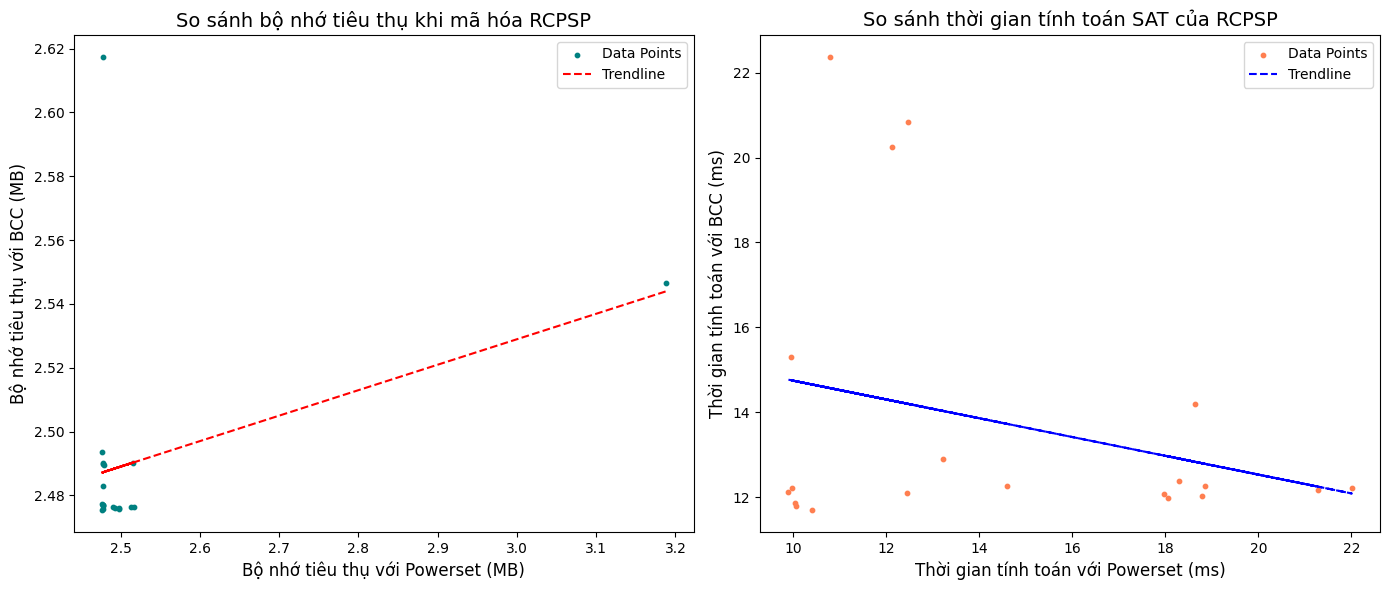

Kết quả trung bình:
Bộ nhớ tiêu thụ trung bình với Powerset: 2.52 MB
Bộ nhớ tiêu thụ trung bình với BCC: 2.49 MB
Thời gian tính toán trung bình với Powerset: 14.49 ms
Thời gian tính toán trung bình với BCC: 13.75 ms


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Hàm đánh giá hiệu suất tiêu thụ bộ nhớ và thời gian tính toán
def evaluate_rcpsp_solver(max_time, activities, relations, resources, consumptions, encoding_type):
    solver = Glucose3()
    vf = VariableFactory()

    tracemalloc.start()  # Khởi động theo dõi bộ nhớ

    # Mã hóa các ràng buộc cho hoạt động
    for activity in activities:
        encode_unique_start_instant_alk(solver, vf, max_time, activity["id"], activity["duration"])
        encode_start_in_time(solver, vf, max_time, activity["id"], activity["duration"])
        encode_runtime(solver, vf, max_time, activity["id"], activity["duration"])

    # Mã hóa các quan hệ giữa các hoạt động
    for relation in relations:
        encode_relation_fs(solver, vf, max_time, relation["task_id_1"], relation["task_id_2"],
                           next(a["duration"] for a in activities if a["id"] == relation["task_id_1"]))

    # Thiết lập tiêu thụ tài nguyên
    for activity in activities:
        if "consumption" not in activity:
            activity["consumption"] = {}

    for consumption in consumptions:
        task_id = consumption["task_id"]
        resource_id = consumption["resource_id"]
        amount = -consumption["amount"]
        for activity in activities:
            if activity["id"] == task_id:
                activity["consumption"][resource_id] = amount

    # Mã hóa tài nguyên theo phương pháp được chọn
    if encoding_type == "Powerset":
        encode_resource_constraint_powerset(solver, vf, max_time, activities, resources)
    elif encoding_type == "BCC":
        encode_resource_constraint_cardinality(solver, vf, max_time, activities, resources)

    # Lưu lượng bộ nhớ sử dụng sau khi mã hóa
    current, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Đo thời gian giải SAT
    start_time = time.time()
    solver.solve()
    end_time = time.time()
    solve_time = (end_time - start_time) * 1000  # Chuyển đổi sang ms

    solver.delete()

    return peak_memory / (1024 * 1024), solve_time  # Bộ nhớ (MB), thời gian tính toán (ms)

# Lưu kết quả đánh giá
num_runs = 20  # Số lần chạy
memory_usage_powerset = []
solve_time_powerset = []
memory_usage_bcc = []
solve_time_bcc = []

for _ in range(num_runs):
    # Đánh giá phương pháp Powerset
    peak_memory_powerset, solve_time_powerset_val = evaluate_rcpsp_solver(
        max_time, activities, relations, resources, consumptions, encoding_type="Powerset"
    )
    memory_usage_powerset.append(peak_memory_powerset)
    solve_time_powerset.append(solve_time_powerset_val)

    # Đánh giá phương pháp BCC
    peak_memory_bcc, solve_time_bcc_val = evaluate_rcpsp_solver(
        max_time, activities, relations, resources, consumptions, encoding_type="BCC"
    )
    memory_usage_bcc.append(peak_memory_bcc)
    solve_time_bcc.append(solve_time_bcc_val)

# Vẽ đồ thị và đường trendline
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Đồ thị 1: Bộ nhớ tiêu thụ khi mã hóa
ax[0].scatter(memory_usage_powerset, memory_usage_bcc, color='teal', s=10, label="Data Points")
ax[0].set_xlabel("Bộ nhớ tiêu thụ với Powerset (MB)", fontsize=12)
ax[0].set_ylabel("Bộ nhớ tiêu thụ với BCC (MB)", fontsize=12)
ax[0].set_title("So sánh bộ nhớ tiêu thụ khi mã hóa RCPSP", fontsize=14)

# Tính và vẽ đường trendline cho bộ nhớ tiêu thụ
slope, intercept, _, _, _ = linregress(memory_usage_powerset, memory_usage_bcc)
trendline_y = np.array(memory_usage_powerset) * slope + intercept
ax[0].plot(memory_usage_powerset, trendline_y, color='red', linestyle="--", label="Trendline")
ax[0].legend()

# Đồ thị 2: Thời gian tính toán SAT
ax[1].scatter(solve_time_powerset, solve_time_bcc, color='coral', s=10, label="Data Points")
ax[1].set_xlabel("Thời gian tính toán với Powerset (ms)", fontsize=12)
ax[1].set_ylabel("Thời gian tính toán với BCC (ms)", fontsize=12)
ax[1].set_title("So sánh thời gian tính toán SAT của RCPSP", fontsize=14)

# Tính và vẽ đường trendline cho thời gian tính toán
slope, intercept, _, _, _ = linregress(solve_time_powerset, solve_time_bcc)
trendline_y = np.array(solve_time_powerset) * slope + intercept
ax[1].plot(solve_time_powerset, trendline_y, color='blue', linestyle="--", label="Trendline")
ax[1].legend()

plt.tight_layout()
plt.show()

# In kết quả trung bình
print("Kết quả trung bình:")
print(f"Bộ nhớ tiêu thụ trung bình với Powerset: {np.mean(memory_usage_powerset):.2f} MB")
print(f"Bộ nhớ tiêu thụ trung bình với BCC: {np.mean(memory_usage_bcc):.2f} MB")
print(f"Thời gian tính toán trung bình với Powerset: {np.mean(solve_time_powerset):.2f} ms")
print(f"Thời gian tính toán trung bình với BCC: {np.mean(solve_time_bcc):.2f} ms")